In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# Load data
Cleanfile = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}
df_clean = pd.read_csv(Cleanfile, dtype=dtype_spec, low_memory=False)
drop =["Unnamed: 0","Em_on_target"]
df_clean = df_clean.drop(drop, axis=1)
#df_clean.drop_duplicates(inplace=True)

In [3]:
# Define the features for each energy type
features_dict = {
    'petrol': ['Fuel consumption', 'Wheelbase_mm', 'Engine_cm3', 'Power_KW', 'Axle_width_steer_mm', 
               'Test_mass', 'Axle_width_other_mm', 'Eco-innovation program', 'Kg_veh', 'year', 
               'Erwltp (g/km)', 'El_Consumpt_whkm'],
    'diesel': ['Wheelbase_mm', 'Axle_width_other_mm', 'Power_KW', 'Test_mass', 'Axle_width_steer_mm', 
               'Kg_veh', 'Engine_cm3', 'Fuel consumption', 'year', 'Erwltp (g/km)', 'Eco-innovation program', 
               'El_Consumpt_whkm'],
    'lpg': ['Kg_veh', 'Fuel consumption', 'Axle_width_steer_mm', 'Axle_width_other_mm', 'year', 'Test_mass', 
            'Power_KW', 'Erwltp (g/km)', 'Engine_cm3', 'Wheelbase_mm', 'Eco-innovation program', 
            'Electric range (km)'],
    'hybrid petrol': ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
                     'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
                     'Eco-innovation program', 'Test_mass', 'Kg_veh'],
    'hybrid diesel': ['El_Consumpt_whkm', 'Axle_width_other_mm', 'Electric range (km)', 'Axle_width_steer_mm', 
                     'year', 'Kg_veh', 'Test_mass', 'Fuel consumption', 'Wheelbase_mm', 'Eco-innovation program', 
                     'Erwltp (g/km)', 'Power_KW']
}

In [4]:
# Function to prepare data for regression
def prepare_data(df, energy_types, features_dict):
    if isinstance(energy_types, list):
        dfs = []
        for energy in energy_types:
            df_energy = df[df['Energy'] == energy].copy()
            if df_energy.empty:
                print(f"No data for energy type: {energy}")
                continue
            df_energy = df_energy[features_dict[energy] + ['CO2_wltp']]
            dfs.append(df_energy)
        if not dfs:
            return pd.DataFrame(), pd.Series(), []
        df_combined = pd.concat(dfs, axis=0)
        features = [feat for energy in energy_types for feat in features_dict[energy]]
        features = list(set(features))  # Remove duplicates
    else:
        df_combined = df[df['Energy'] == energy_types].copy()
        if df_combined.empty:
            print(f"No data for energy type: {energy_types}")
            return pd.DataFrame(), pd.Series(), []
        features = features_dict[energy_types]
    
    X = df_combined[features]
    y = df_combined['CO2_wltp']
    
    return X, y, features

In [16]:
# Regression function with cross-validation and regularization
def regression_with_cv_and_regularization(df, energy_types, features_dict, alphas, degree=2, model_type='ridge'):
    # Prepare data
    X, y, feature_names = prepare_data(df, energy_types, features_dict)
    
    if X.empty or y.empty:
        print(f"No data available for energy types: {energy_types}")
        return None, None, None
    
    # Handle missing values
    X = X.fillna(X.mean())  # Avoid SettingWithCopyWarning
    
    # Print the number of features before polynomial transformation
    print(f"Number of features before polynomial transformation: {X.shape[1]}")
    
    # Polynomial Features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Print the number of features after polynomial transformation
    print(f"Number of features after polynomial transformation: {X_poly.shape[1]}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_poly)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Parameter grid for alpha
    param_grid = {'alpha': alphas}
    
    # Choose model type
    if model_type == 'ridge':
        model = Ridge()
    elif model_type == 'lasso':
        model = Lasso()
    elif model_type == 'elasticnet':
        model = ElasticNet()
    else:
        raise ValueError("Model type must be 'ridge', 'lasso', or 'elasticnet'")
    
    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Regression with RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=kf, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Best model
    best_model = random_search.best_estimator_
    best_alpha = random_search.best_params_['alpha']
    
    # Predictions with best model
    y_pred_best = best_model.predict(X_test)
    
    # Evaluation of best model
    best_r2 = r2_score(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    
    # Cross-validated R^2
    cv_r2 = cross_val_score(best_model, X_scaled, y, cv=kf, scoring='r2').mean()
    
    # Results reporting
    print(f"Energy Type: {'All' if isinstance(energy_types, list) else energy_types}")
    print(f"Best Alpha: {best_alpha}")
    print(f"Best R^2 Score: {best_r2}")
    print(f"Mean Squared Error: {mse_best}")
    print(f"Cross-validated R^2: {cv_r2}")
    
    # Save the best model
    #model_filename = f"best_model_{energy_types.replace(' ', '_') if isinstance(energy_types, str) else 'all'}.joblib"
    #joblib.dump(best_model, model_filename)
    #print(f"Model saved as {model_filename}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter plot of actual vs predicted for best model
    sns.scatterplot(x=y_test, y=y_pred_best, ax=axes[0])
    axes[0].set_xlabel('Actual CO2_wltp')
    axes[0].set_ylabel('Predicted CO2_wltp')
    axes[0].set_title(f'Regression Results for {"All Energies" if isinstance(energy_types, list) else energy_types}')
    
    # R^2 scores vs alpha plot
    results_df = pd.DataFrame(random_search.cv_results_)
    sns.lineplot(x='param_alpha', y='mean_test_score', data=results_df, ax=axes[1])
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Mean CV R^2 Score')
    axes[1].set_title('Mean CV R^2 Score vs Alpha')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance for best model
    original_features = poly.get_feature_names_out(feature_names)
    coef_df = pd.DataFrame({'Feature': original_features, 'Coefficient': np.abs(best_model.coef_)})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    print("Feature Importances:")
    for feature, coef in zip(coef_df['Feature'], coef_df['Coefficient']):
        print(f"{feature}: {coef}")
    
    # Visualization of feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()
    
    return best_model, best_r2, mse_best

Number of features before polynomial transformation: 12
Number of features after polynomial transformation: 12
Energy Type: petrol
Best Alpha: 2.8330961018393297
Best R^2 Score: 0.6679482805355084
Mean Squared Error: 114.98749355088799
Cross-validated R^2: 0.6679562134433172


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


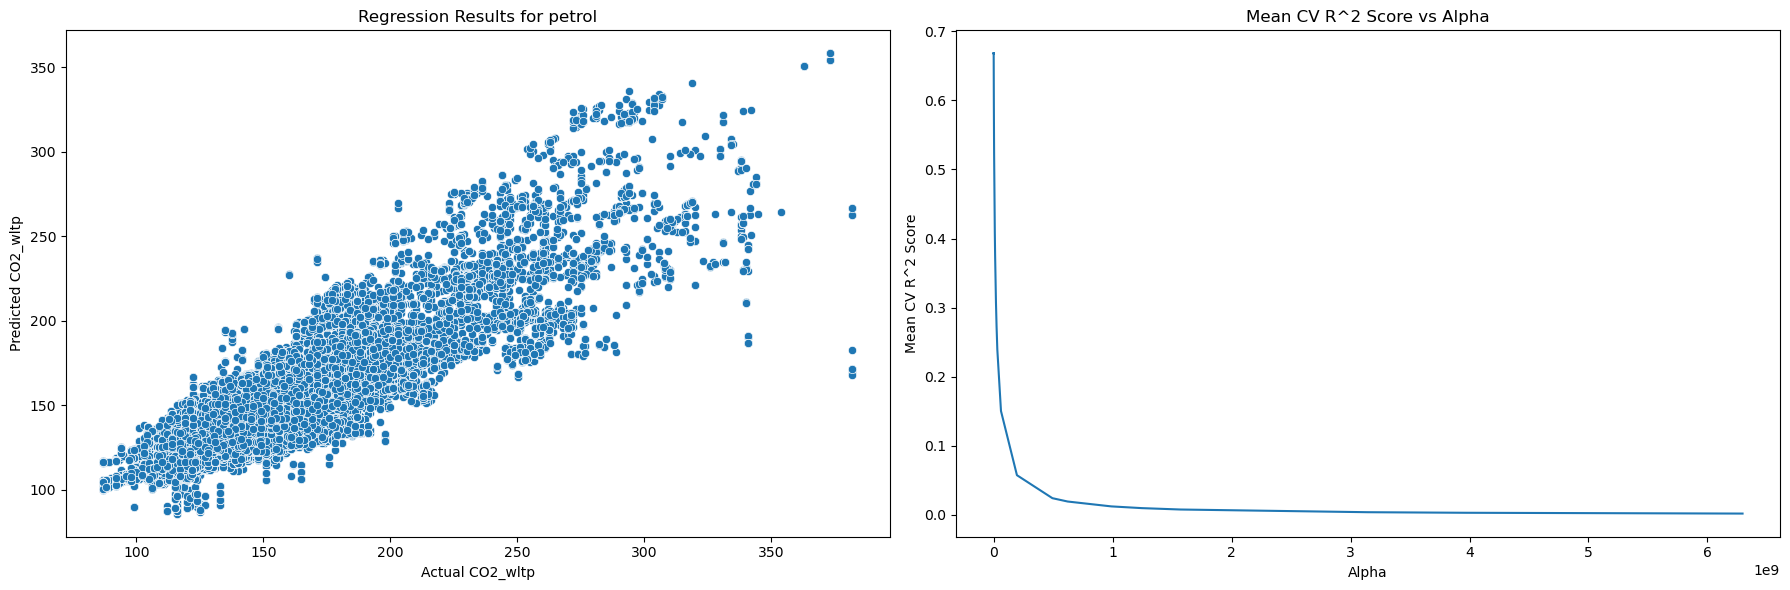

Feature Importances:
Power_KW: 12.110915063760816
Test_mass: 7.663170459022898
year: 5.775417718269134
Engine_cm3: 4.742200908256958
Fuel consumption: 4.682204147056395
Axle_width_other_mm: 2.4224294406538727
Kg_veh: 1.892422510040344
Erwltp (g/km): 1.6846388098280565
Eco-innovation program: 0.8246347353953032
Axle_width_steer_mm: 0.6037792434362533
Wheelbase_mm: 0.2477031197137856
El_Consumpt_whkm: 0.24350277260152126


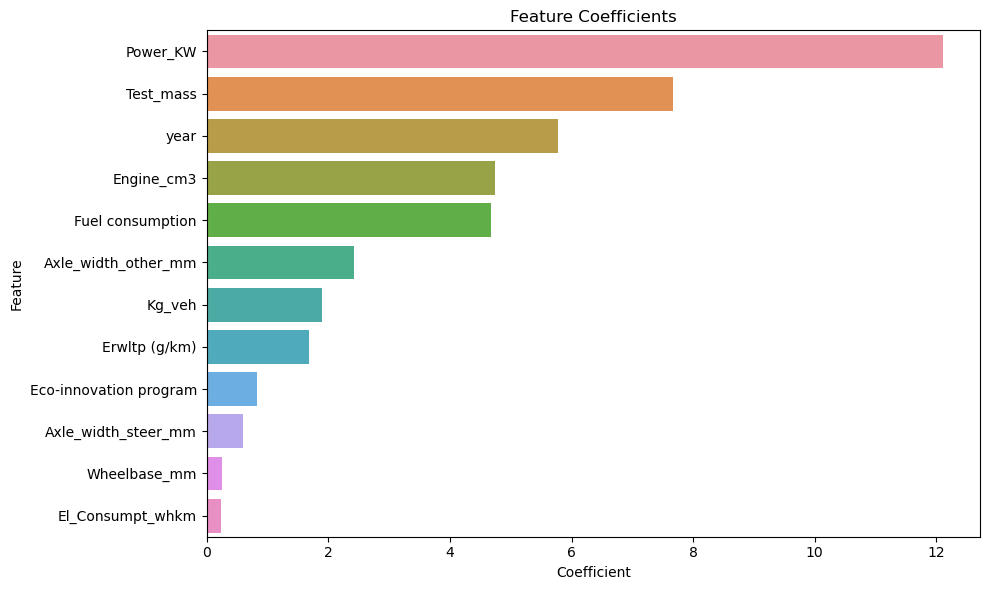

Number of features before polynomial transformation: 12
Number of features after polynomial transformation: 12
Energy Type: diesel
Best Alpha: 1.122667773510816
Best R^2 Score: 0.8594732045148983
Mean Squared Error: 65.38888544208177
Cross-validated R^2: 0.859577448821336


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


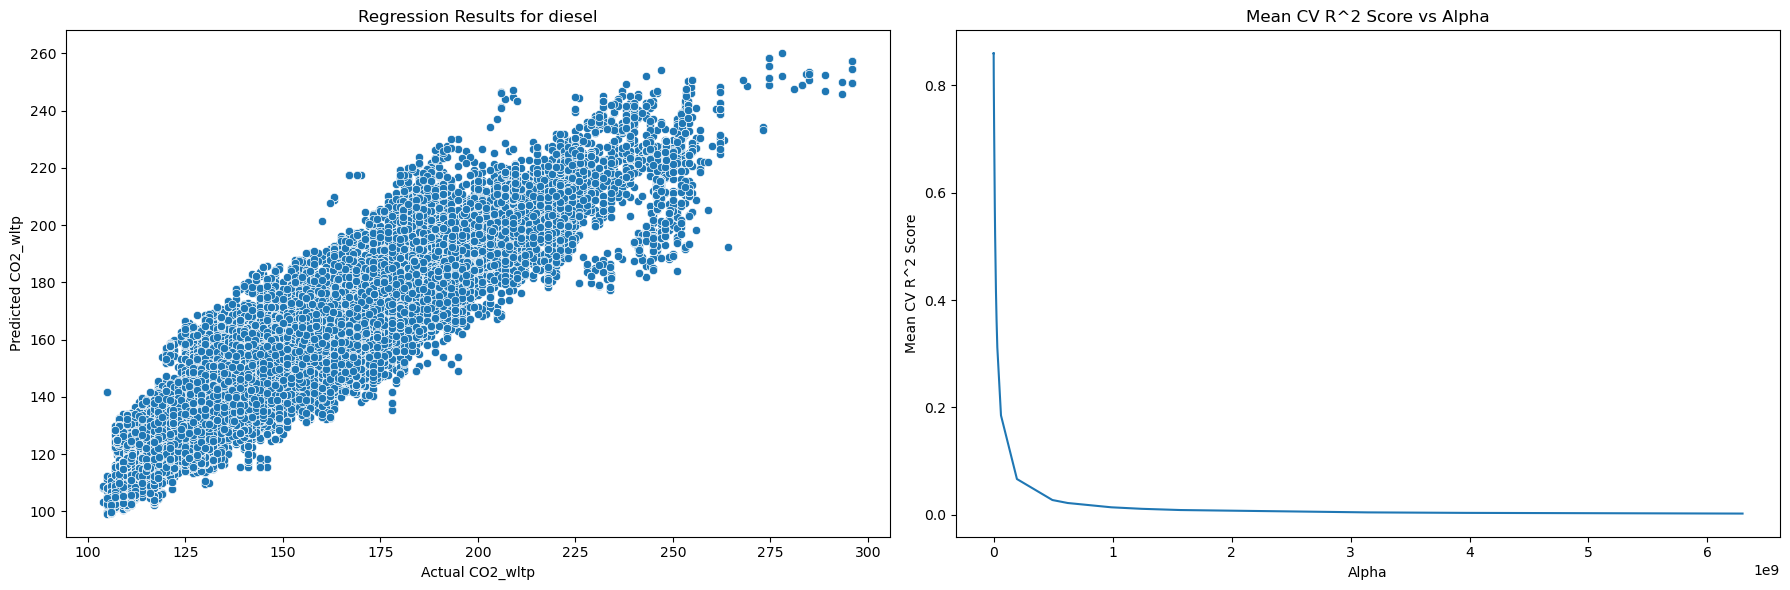

Feature Importances:
Test_mass: 17.894750613209
Kg_veh: 5.024893502519409
Wheelbase_mm: 3.711421234104673
year: 3.3866086293809845
Axle_width_steer_mm: 2.7278813853247588
Fuel consumption: 1.9169808699049042
Eco-innovation program: 1.8945304229486626
Axle_width_other_mm: 1.8044080908911435
Power_KW: 1.197300143529733
Erwltp (g/km): 0.5800764120785682
Engine_cm3: 0.17953811472800874
El_Consumpt_whkm: 0.03771376002098044


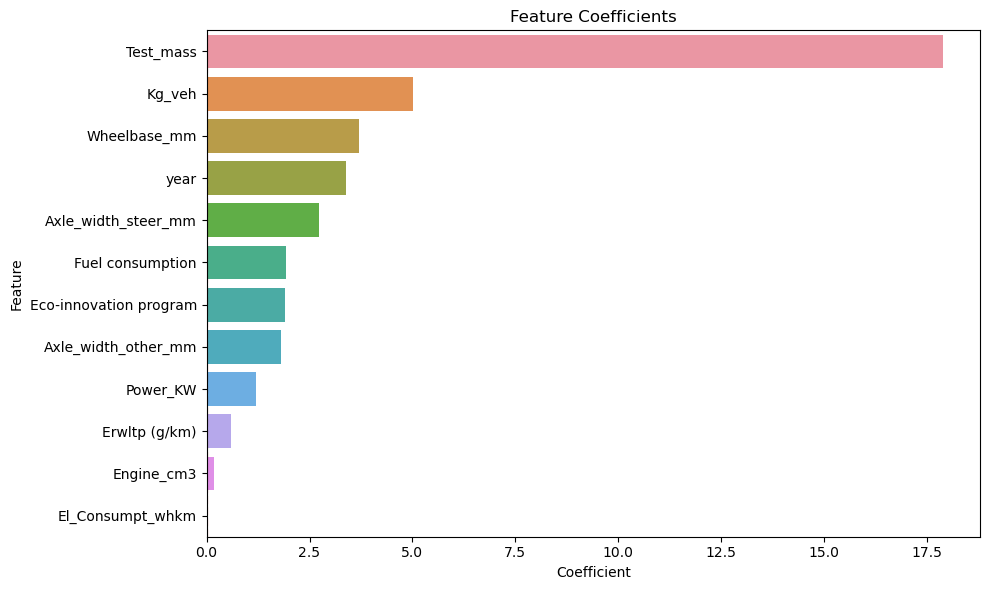

Number of features before polynomial transformation: 12
Number of features after polynomial transformation: 12
Energy Type: lpg
Best Alpha: 0.35297073027306575
Best R^2 Score: 0.8891760538452124
Mean Squared Error: 7.894690068147286
Cross-validated R^2: 0.8900272246906639


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


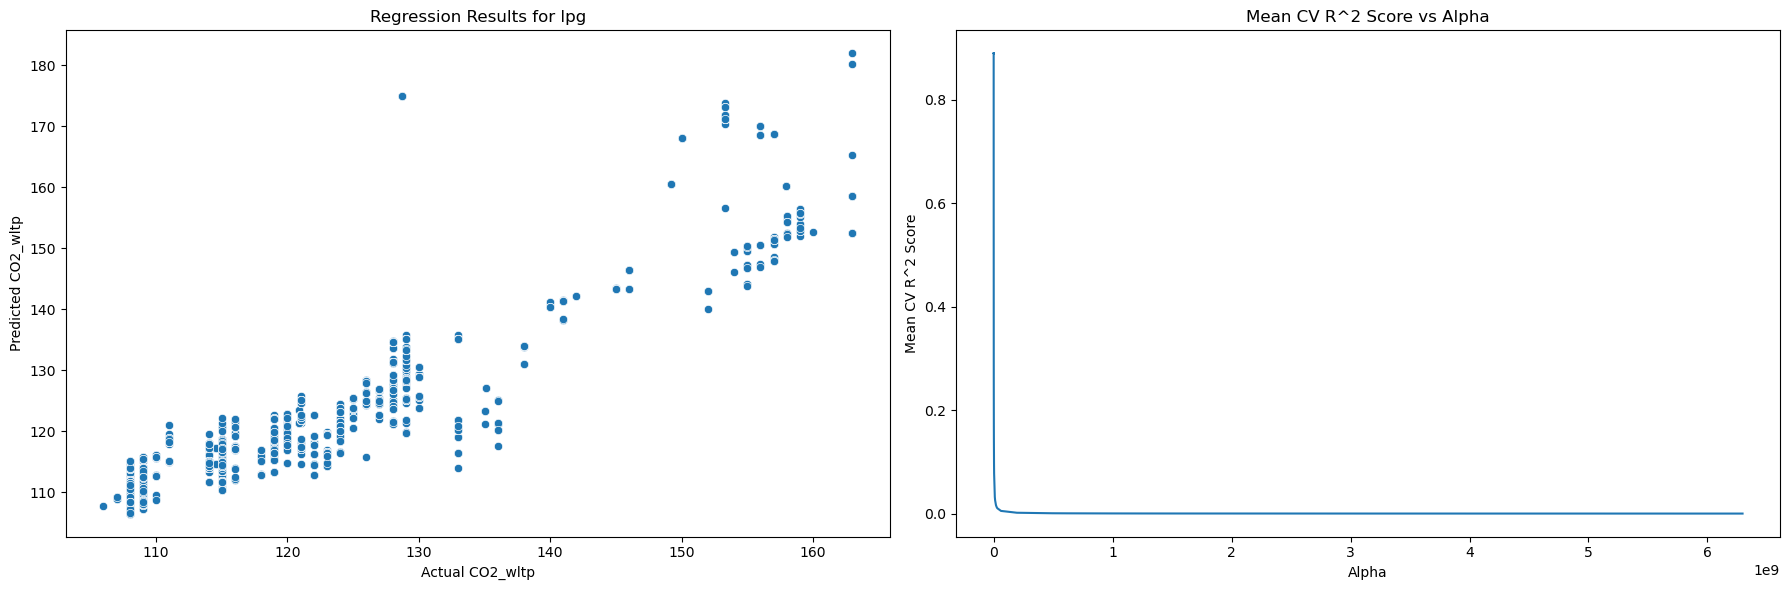

Feature Importances:
Test_mass: 12.761283464788756
Axle_width_other_mm: 10.87453777990034
Axle_width_steer_mm: 10.703741880015125
Kg_veh: 6.56540188601653
Wheelbase_mm: 2.6798447663759926
year: 2.6352166231485854
Eco-innovation program: 2.198949162809659
Erwltp (g/km): 1.8914602538591798
Engine_cm3: 1.8051982379909655
Power_KW: 1.641608289845251
Fuel consumption: 0.9973905309830136
Electric range (km): 0.0


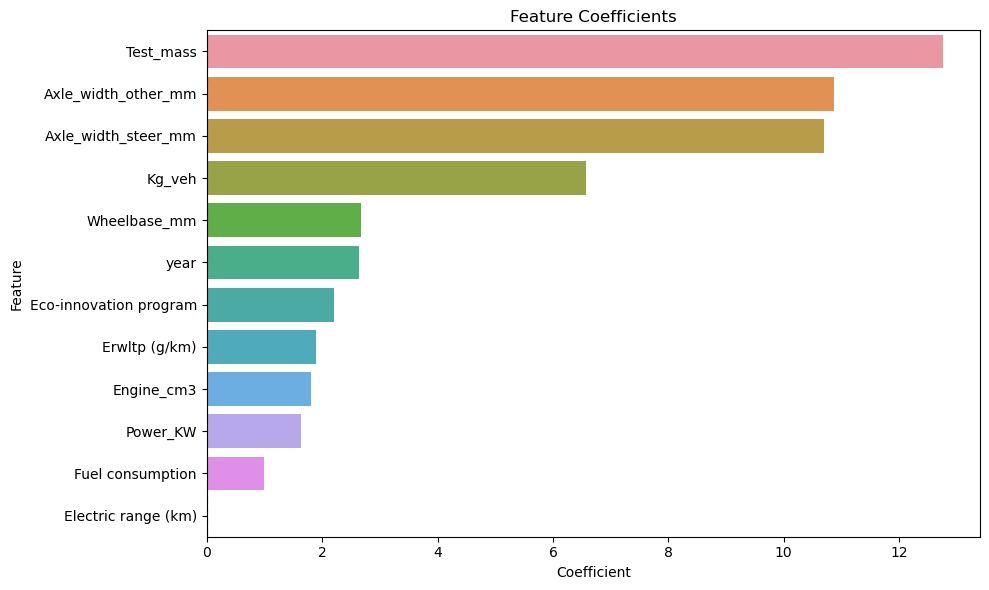

Number of features before polynomial transformation: 12
Number of features after polynomial transformation: 12
Energy Type: hybrid petrol
Best Alpha: 182.51834943190462
Best R^2 Score: 0.41211013985630485
Mean Squared Error: 176.67745815582717
Cross-validated R^2: 0.41055048997701327


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


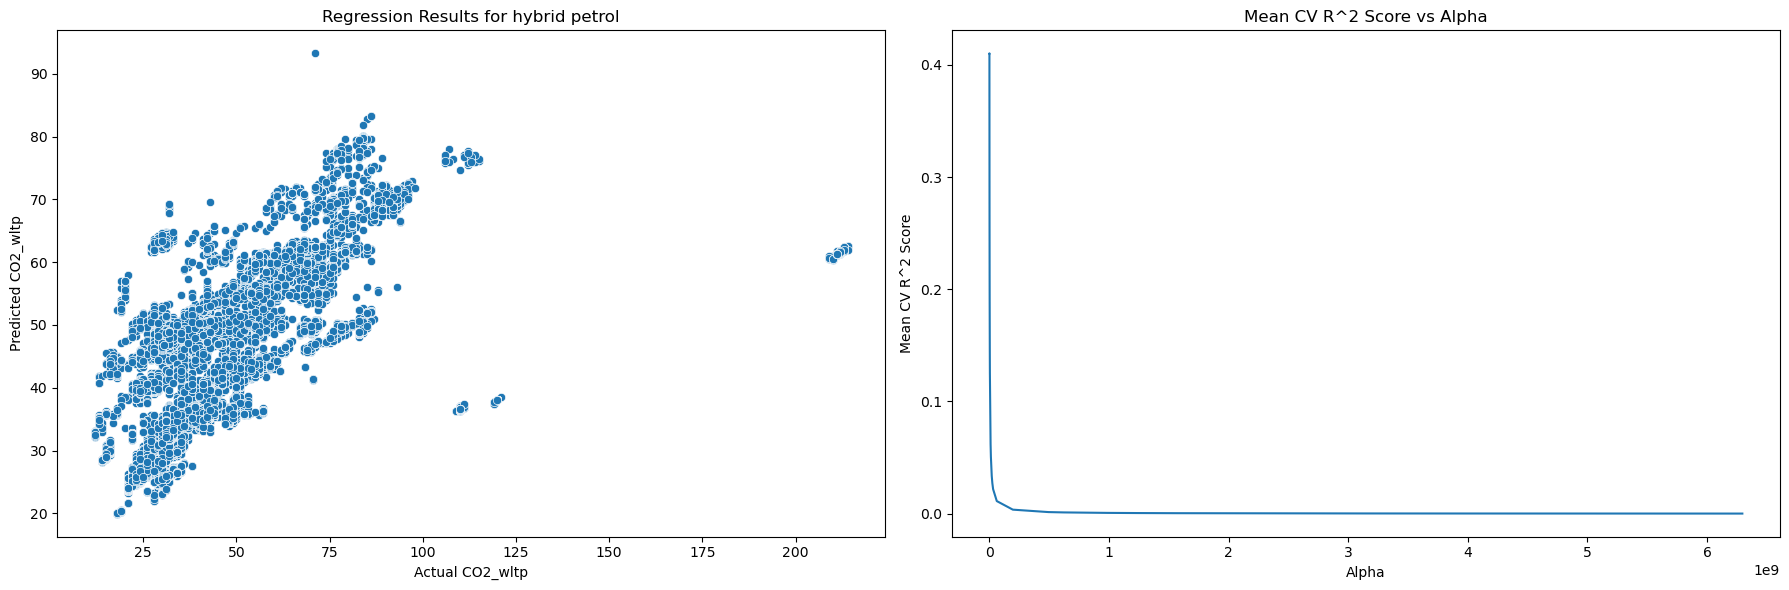

Feature Importances:
Fuel consumption: 6.834484329555084
Test_mass: 5.3886861911663235
Kg_veh: 3.9933245151389474
Electric range (km): 2.0714588022931455
Engine_cm3: 1.5540137962133382
Power_KW: 1.4073481567611432
Axle_width_other_mm: 1.1191420978193383
El_Consumpt_whkm: 0.8145566888868735
Axle_width_steer_mm: 0.7203120166901351
Wheelbase_mm: 0.3666505167953677
year: 0.1683232140118536
Eco-innovation program: 0.05788399975111383


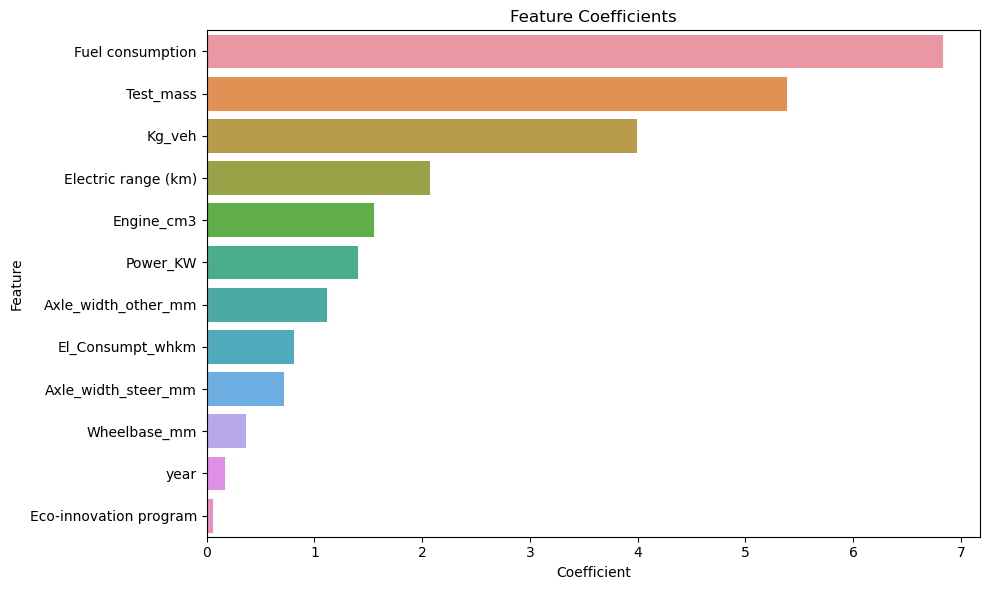

Number of features before polynomial transformation: 12
Number of features after polynomial transformation: 12
Energy Type: hybrid diesel
Best Alpha: 0.11097524964120745
Best R^2 Score: 0.9928583284361231
Mean Squared Error: 1.2543770088112194
Cross-validated R^2: 0.9928626454884577


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


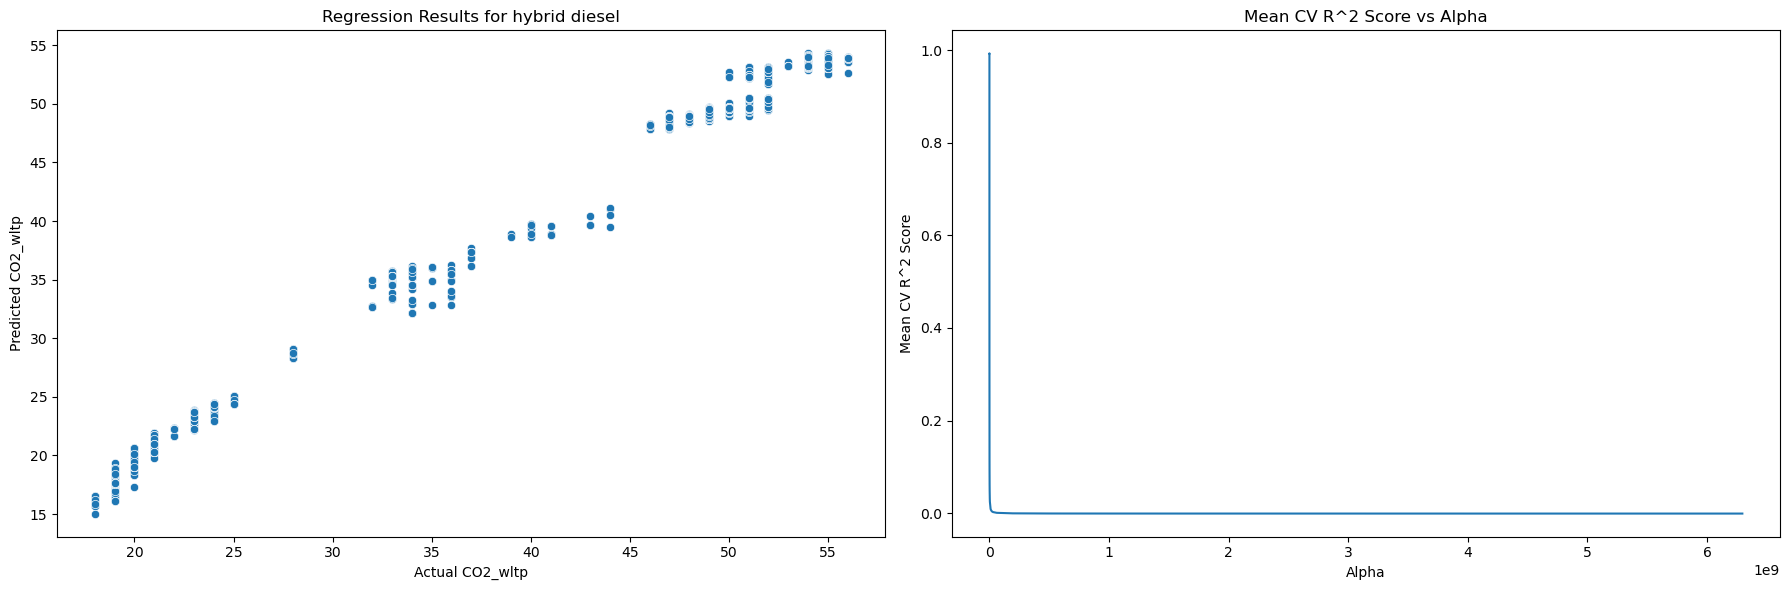

Feature Importances:
Electric range (km): 15.946167824796646
Axle_width_steer_mm: 6.300145608937656
Kg_veh: 5.573876863236255
Axle_width_other_mm: 4.514730295484564
Test_mass: 0.9892874480168735
Wheelbase_mm: 0.8960370058621143
El_Consumpt_whkm: 0.6176190171138739
Fuel consumption: 0.2649568886928934
year: 0.2400388144832911
Eco-innovation program: 0.0
Erwltp (g/km): 0.0
Power_KW: 0.0


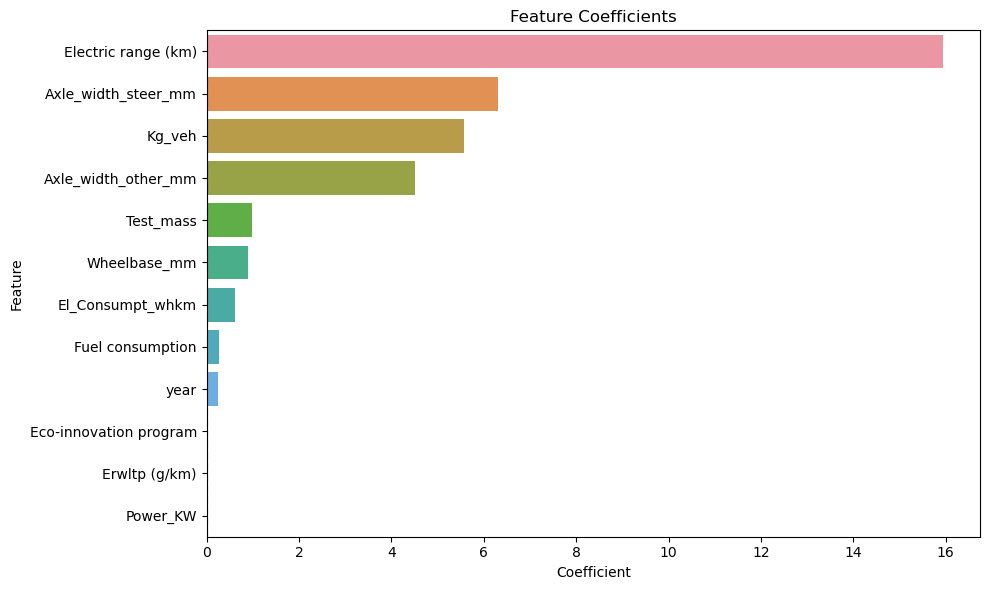

In [18]:
# Apply regression with cross-validation and regularization for each energy type and all together
alphas = np.logspace(-10, 10, 200)
results = {}
for energy, features in features_dict.items():
    results[energy] = regression_with_cv_and_regularization(df_clean, energy, features_dict, alphas, degree=1, model_type='ridge')

In [ ]:
# Run regression on all energies together
all_energies = list(features_dict.keys())
results['all_energies'] = regression_with_cv_and_regularization(df_clean, all_energies, features_dict, alphas, degree=1, model_type='ridge')

Number of features before polynomial transformation: 13
Number of features after polynomial transformation: 13
